In [ ]:
!python -m pip install torch torchvision torchaudio


In [3]:
!python -m pip install matplotlib
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.9/303.9 kB 3.4 MB/s eta 0:00:0000:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.3 MB/s eta 0:00:0000:0100:01
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


In [5]:
img = io.read_image('/home/digitalopt/Pictures/Webcam/cards2/card.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1080, 1920])


tensor([[[2, 2, 2, 2],
         [2, 2, 2, 2],
         [2, 2, 2, 2]],

        [[6, 6, 6, 6],
         [6, 6, 6, 6],
         [6, 6, 6, 6]]], dtype=torch.uint8)

In [6]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [7]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 266, 39900)

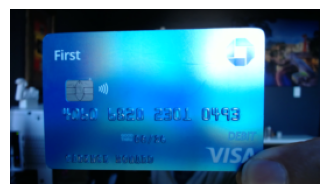

In [8]:
show_img(img2)

In [10]:
%%time
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)


img_g = rgb2grey_py(img2)

CPU times: user 781 ms, sys: 0 ns, total: 781 ms
Wall time: 780 ms


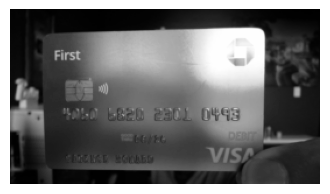

In [11]:
show_img(img_g, cmap='gray')

In [15]:
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [13]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)

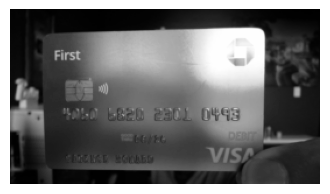

In [16]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

In [17]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i < n : out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

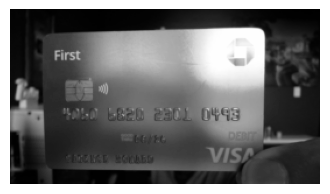

In [18]:
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

In [19]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'
!python -m pip install wurlitzer
%load_ext wurlitzer

In [26]:
!python -m pip install ninja

  Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl.metadata (5.3 kB)
Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl (307 kB)


In [20]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [23]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAExpetion.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [24]:
# unsigned char* = uint8, the * is a pointer, which is treated like an array
# __global__ directs CUDA to reserve memory on the device
cuda_src = cuda_begin + r'''
__global__ void rgb2grey_kernel(unsigned char* x,unsigned char* out, int n) {
  int i = blockidx.x * blockdim.x + threadidx.x;
  if (i < n) {
    out[i] = 0.2989f * x[i] + 0.5870f * x[i + n] + 0.1140f * x[i + 2 * n];
  }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
  CHECK_INPUT(inout);
  int h = input.size(1);
  int w = input.size(2);
  printf("h*w: %d*%d\n", h,w);
  auto output = torch::empty({h,w},input.options());
  int threads = 256;
  rgb2grey_kernel<<<cdiv(w*h, threds), threads>>>(
    input.data_ptr<unisgned char>(), output.data_ptr<unisigned char>(), w*h);
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return output;
}
'''

In [27]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /home/digitalopt/.cache/torch_extensions/py312_cu121 as PyTorch extensions root...
No modifications detected for re-loaded extension module inline_ext, skipping build step...
Loading extension module inline_ext...


ImportError: /home/digitalopt/.cache/torch_extensions/py312_cu121/inline_ext/inline_ext.so: cannot open shared object file: No such file or directory